# Orchestration de Pipelines Audio

**Module :** 03-Audio-Orchestration  
**Niveau :** Avance  
**Technologies :** STT->LLM->TTS pipelines, faster-whisper, OpenAI GPT, Kokoro/Chatterbox, ~14 GB VRAM  
**Duree estimee :** 60 minutes  

## Objectifs d'Apprentissage

- [ ] Construire un pipeline STT->LLM->TTS (question audio -> transcription -> reponse GPT -> synthese vocale)
- [ ] Implementer un pipeline de traduction audio (FR audio -> EN texte -> EN speech)
- [ ] Generer un podcast multi-voix a partir d'un sujet (2+ voix discutant d'un theme)
- [ ] Gerer les erreurs et les retries dans les pipelines
- [ ] Profiler les performances par etape du pipeline
- [ ] Identifier les goulots d'etranglement et optimiser

## Prerequis

- Notebook 03-1 recommande (comparaison des modeles)
- GPU NVIDIA avec au moins 14 GB VRAM
- Cle API OpenAI configuree (`OPENAI_API_KEY` dans `.env`)
- `pip install faster-whisper openai soundfile kokoro`

**Navigation :** [<< 03-1](03-1-Multi-Model-Audio-Comparison.ipynb) | [Index](../README.md) | [Suivant >>](03-3-Realtime-Voice-API.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres pipeline
pipeline_mode = "stt_llm_tts"      # "stt_llm_tts", "translation", "podcast"
llm_model = "gpt-4o-mini"          # Modele LLM pour le traitement
tts_voice = "alloy"                # Voix OpenAI pour le TTS
device = "cuda"                    # "cuda" ou "cpu"

# Configuration
save_results = True                # Sauvegarder les fichiers generes
max_retries = 3                    # Nombre max de retries par etape
generate_podcast = True            # Generer le podcast multi-voix

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import gc
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from dataclasses import dataclass, field
import logging

import numpy as np
import soundfile as sf
from IPython.display import Audio, display, HTML

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.audio_helpers import play_audio, save_audio
        print("Helpers audio importes")
    except ImportError:
        print("Helpers audio non disponibles - mode autonome")

# Repertoires
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'audio' / 'pipelines'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('audio_pipelines')

# Verification GPU
gpu_available = False
try:
    import torch
    gpu_available = torch.cuda.is_available()
    if gpu_available:
        gpu_name = torch.cuda.get_device_name(0)
        gpu_vram = torch.cuda.get_device_properties(0).total_mem / (1024**3)
        print(f"GPU : {gpu_name} ({gpu_vram:.1f} GB VRAM)")
    else:
        print("GPU non disponible - pipelines locaux seront plus lents")
        if device == "cuda":
            device = "cpu"
            print("Fallback vers CPU")
except ImportError:
    print("torch non installe")
    device = "cpu"

print(f"\nOrchestration de Pipelines Audio")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}, Device : {device}")
print(f"Pipeline : {pipeline_mode}")
print(f"LLM : {llm_model}, TTS voice : {tts_voice}")
print(f"Sortie : {OUTPUT_DIR}")

Helpers audio importes


GPU non disponible - pipelines locaux seront plus lents
Fallback vers CPU

Orchestration de Pipelines Audio
Date : 2026-02-26 08:22:03
Mode : interactive, Device : cpu
Pipeline : stt_llm_tts
LLM : gpt-4o-mini, TTS voice : alloy
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\pipelines


In [3]:
# Chargement .env et validation API
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Validation cle OpenAI (necessaire pour LLM et TTS API)
openai_key = os.getenv('OPENAI_API_KEY')
openai_available = False

if openai_key:
    try:
        from openai import OpenAI
        client = OpenAI(api_key=openai_key)
        openai_available = True
        print(f"OPENAI_API_KEY valide - API disponible")
        print(f"LLM : {llm_model}")
    except Exception as e:
        print(f"Erreur OpenAI : {str(e)[:100]}")
else:
    if notebook_mode == "batch":
        print("Mode batch sans API : validation structurelle uniquement")
    else:
        raise ValueError(
            "OPENAI_API_KEY manquante dans .env\n"
            "Les pipelines necessitent l'API OpenAI pour le LLM et le TTS."
        )

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env


OPENAI_API_KEY valide - API disponible
LLM : gpt-4o-mini


## Section 1 : Architecture des pipelines

Un pipeline audio orchestre plusieurs modeles en sequence. Chaque etape transforme les donnees et les passe a la suivante.

### Pipeline STT -> LLM -> TTS

| Etape | Entree | Modele | Sortie |
|-------|--------|--------|--------|
| 1. STT | Audio WAV | faster-whisper | Texte transcrit |
| 2. LLM | Texte (question) | GPT-4o-mini | Texte (reponse) |
| 3. TTS | Texte (reponse) | OpenAI TTS | Audio WAV |

### Pipeline de traduction

| Etape | Entree | Modele | Sortie |
|-------|--------|--------|--------|
| 1. STT | Audio FR | faster-whisper | Texte FR |
| 2. LLM | Texte FR | GPT-4o-mini | Texte EN |
| 3. TTS | Texte EN | OpenAI TTS | Audio EN |

### Gestion des erreurs

| Type d'erreur | Strategie | Retries |
|--------------|-----------|--------|
| Timeout API | Retry exponentiel | 3 |
| Erreur reseau | Retry avec backoff | 3 |
| GPU OOM | Fallback CPU | 1 |
| Audio corrompu | Skip avec log | 0 |

In [4]:
# Framework de pipeline avec gestion d'erreurs
print("FRAMEWORK DE PIPELINE")
print("=" * 45)


@dataclass
class PipelineStep:
    """Resultat d'une etape du pipeline."""
    name: str
    input_type: str
    output_type: str
    duration_s: float = 0.0
    success: bool = False
    error: Optional[str] = None
    output_data: Any = None


@dataclass
class PipelineResult:
    """Resultat complet d'un pipeline."""
    name: str
    steps: List[PipelineStep] = field(default_factory=list)
    total_duration_s: float = 0.0
    success: bool = False

    def summary(self) -> str:
        lines = [f"Pipeline: {self.name}"]
        lines.append(f"Statut: {'Succes' if self.success else 'Echec'}")
        lines.append(f"Duree totale: {self.total_duration_s:.2f}s")
        for step in self.steps:
            status = 'OK' if step.success else f'ERREUR: {step.error}'
            lines.append(f"  {step.name}: {step.duration_s:.2f}s [{status}]")
        return "\n".join(lines)


def retry_with_backoff(func, max_retries: int = 3, base_delay: float = 1.0):
    """Executer une fonction avec retry exponentiel."""
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            delay = base_delay * (2 ** attempt)
            logger.warning(f"Tentative {attempt+1}/{max_retries} echouee: {e}. Retry dans {delay}s")
            time.sleep(delay)


# Statistiques globales
pipeline_results: List[PipelineResult] = []

print("Framework initialise")
print(f"Max retries : {max_retries}")
print(f"Gestion d'erreurs : retry exponentiel + fallback")

FRAMEWORK DE PIPELINE
Framework initialise
Max retries : 3
Gestion d'erreurs : retry exponentiel + fallback


## Section 2 : Pipeline STT -> LLM -> TTS

Ce pipeline permet de poser une question en audio et d'obtenir une reponse vocale generee par un LLM. C'est la base d'un assistant vocal.

| Composant | Modele | Role |
|-----------|--------|------|
| STT | faster-whisper large-v3-turbo | Transcription de la question |
| LLM | GPT-4o-mini | Generation de la reponse |
| TTS | OpenAI tts-1 | Synthese vocale de la reponse |

In [5]:
# Pipeline STT -> LLM -> TTS
print("PIPELINE STT -> LLM -> TTS")
print("=" * 45)

# Generer un audio de test (question)
question_text = "What are the main advantages of using local AI models compared to cloud APIs?"
question_path = OUTPUT_DIR / "question.wav"

if openai_available:
    result = PipelineResult(name="stt_llm_tts")

    # 0. Generer l'audio de la question
    print("Etape 0 : Generation de la question audio...")
    response = client.audio.speech.create(
        model="tts-1", voice="nova", input=question_text, response_format="wav"
    )
    with open(question_path, 'wb') as f:
        f.write(response.content)
    print(f"  Question : {question_text}")
    display(Audio(data=response.content, autoplay=False))

    # --- ETAPE 1 : STT ---
    print(f"\nEtape 1 : STT (transcription)...")
    step1 = PipelineStep(name="STT", input_type="audio", output_type="text")

    try:
        start_time = time.time()

        # Essayer faster-whisper local d'abord
        stt_used = "API"
        try:
            from faster_whisper import WhisperModel
            stt_model = WhisperModel("large-v3-turbo", device=device,
                                     compute_type="float16" if device == "cuda" else "int8")
            segments, info = stt_model.transcribe(str(question_path), beam_size=5)
            transcribed_text = " ".join([s.text.strip() for s in segments])
            stt_used = "local (faster-whisper)"
            del stt_model
            gc.collect()
            if gpu_available:
                torch.cuda.empty_cache()
        except ImportError:
            # Fallback vers API Whisper
            with open(question_path, "rb") as f:
                transcribed_text = client.audio.transcriptions.create(
                    model="whisper-1", file=f, response_format="text"
                )
            stt_used = "API (whisper-1)"

        step1.duration_s = time.time() - start_time
        step1.success = True
        step1.output_data = transcribed_text
        print(f"  Methode : {stt_used}")
        print(f"  Transcription : {transcribed_text}")
        print(f"  Duree : {step1.duration_s:.2f}s")
    except Exception as e:
        step1.error = str(e)[:100]
        print(f"  Erreur STT : {step1.error}")
    result.steps.append(step1)

    # --- ETAPE 2 : LLM ---
    print(f"\nEtape 2 : LLM (generation reponse)...")
    step2 = PipelineStep(name="LLM", input_type="text", output_type="text")

    if step1.success:
        try:
            start_time = time.time()

            def call_llm():
                return client.chat.completions.create(
                    model=llm_model,
                    messages=[
                        {"role": "system", "content": "You are a helpful AI assistant. Answer concisely in 2-3 sentences."},
                        {"role": "user", "content": transcribed_text}
                    ],
                    max_tokens=200
                )

            llm_response = retry_with_backoff(call_llm, max_retries=max_retries)
            answer_text = llm_response.choices[0].message.content

            step2.duration_s = time.time() - start_time
            step2.success = True
            step2.output_data = answer_text
            print(f"  Modele : {llm_model}")
            print(f"  Reponse : {answer_text}")
            print(f"  Tokens : {llm_response.usage.total_tokens}")
            print(f"  Duree : {step2.duration_s:.2f}s")
        except Exception as e:
            step2.error = str(e)[:100]
            print(f"  Erreur LLM : {step2.error}")
    else:
        step2.error = "Etape precedente en echec"
        print(f"  Skipped : STT en echec")
    result.steps.append(step2)

    # --- ETAPE 3 : TTS ---
    print(f"\nEtape 3 : TTS (synthese vocale)...")
    step3 = PipelineStep(name="TTS", input_type="text", output_type="audio")

    if step2.success:
        try:
            start_time = time.time()

            def call_tts():
                return client.audio.speech.create(
                    model="tts-1", voice=tts_voice,
                    input=answer_text, response_format="wav"
                )

            tts_response = retry_with_backoff(call_tts, max_retries=max_retries)

            step3.duration_s = time.time() - start_time
            step3.success = True
            step3.output_data = tts_response.content

            answer_path = OUTPUT_DIR / "pipeline_answer.wav"
            with open(answer_path, 'wb') as f:
                f.write(tts_response.content)

            print(f"  Voix : {tts_voice}")
            print(f"  Taille : {len(tts_response.content)/1024:.1f} KB")
            print(f"  Duree : {step3.duration_s:.2f}s")
            print(f"\n  Reponse audio :")
            display(Audio(data=tts_response.content, autoplay=False))
        except Exception as e:
            step3.error = str(e)[:100]
            print(f"  Erreur TTS : {step3.error}")
    else:
        step3.error = "Etape precedente en echec"
        print(f"  Skipped : LLM en echec")
    result.steps.append(step3)

    # Resume du pipeline
    result.total_duration_s = sum(s.duration_s for s in result.steps)
    result.success = all(s.success for s in result.steps)
    pipeline_results.append(result)

    print(f"\n{result.summary()}")
else:
    print("API OpenAI non disponible - pipeline desactive")

PIPELINE STT -> LLM -> TTS
Etape 0 : Generation de la question audio...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Question : What are the main advantages of using local AI models compared to cloud APIs?



Etape 1 : STT (transcription)...


INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/mobiuslabsgmbh/faster-whisper-large-v3-turbo/revision/main "HTTP/1.1 307 Temporary Redirect"


INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/dropbox-dash/faster-whisper-large-v3-turbo/revision/main "HTTP/1.1 200 OK"


INFO:faster_whisper:Processing audio with duration 00:04.650


INFO:faster_whisper:Detected language 'en' with probability 1.00


  Methode : local (faster-whisper)
  Transcription : What are the main advantages of using local AI models compared to cloud APIs?
  Duree : 21.52s

Etape 2 : LLM (generation reponse)...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Modele : gpt-4o-mini
  Reponse : Local AI models offer enhanced privacy and data security since sensitive data does not need to be transmitted over the internet. They also provide lower latency and faster response times, as processing happens on-device without reliance on external servers. Additionally, local models can operate without internet connectivity, ensuring continuous functionality in offline scenarios.
  Tokens : 104
  Duree : 1.27s

Etape 3 : TTS (synthese vocale)...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Voix : alloy
  Taille : 1129.7 KB
  Duree : 3.08s

  Reponse audio :



Pipeline: stt_llm_tts
Statut: Succes
Duree totale: 25.86s
  STT: 21.52s [OK]
  LLM: 1.27s [OK]
  TTS: 3.08s [OK]


### Interpretation : Pipeline STT -> LLM -> TTS

| Etape | Latence typique | Goulot d'etranglement |
|-------|----------------|----------------------|
| STT (local) | 0.5-2s | GPU / taille audio |
| STT (API) | 1-3s | Reseau |
| LLM | 1-3s | Generation de tokens |
| TTS | 1-2s | Reseau / synthese |
| **Total** | **3-8s** | **LLM souvent le plus lent** |

**Points cles** :
1. La latence totale du pipeline est la somme des latences individuelles
2. Le LLM est souvent le goulot d'etranglement (generation autoregressive)
3. Le retry exponentiel protege contre les erreurs transitoires
4. Pour du temps reel, privilegier des modeles plus petits (gpt-4o-mini)

## Section 3 : Pipeline de traduction audio

Ce pipeline traduit un message vocal d'une langue a une autre en combinant STT, traduction LLM et TTS.

| Etape | Description | Modele |
|-------|-------------|--------|
| 1. Transcription | Audio FR -> Texte FR | faster-whisper |
| 2. Traduction | Texte FR -> Texte EN | GPT-4o-mini |
| 3. Synthese | Texte EN -> Audio EN | OpenAI TTS |

In [6]:
# Pipeline de traduction audio FR -> EN
print("PIPELINE DE TRADUCTION AUDIO")
print("=" * 45)

french_text = (
    "L'intelligence artificielle permet aujourd'hui de traduire automatiquement "
    "la parole d'une langue a une autre en temps quasi reel. "
    "Cette technologie ouvre des perspectives pour la communication internationale."
)

if openai_available:
    result = PipelineResult(name="translation_fr_en")

    # 0. Generer l'audio FR
    print("Etape 0 : Generation de l'audio source (FR)...")
    fr_response = client.audio.speech.create(
        model="tts-1", voice="nova", input=french_text, response_format="wav"
    )
    fr_path = OUTPUT_DIR / "translation_source_fr.wav"
    with open(fr_path, 'wb') as f:
        f.write(fr_response.content)
    print(f"  Texte FR : {french_text[:80]}...")
    display(Audio(data=fr_response.content, autoplay=False))

    # --- ETAPE 1 : STT (FR) ---
    print(f"\nEtape 1 : Transcription (FR)...")
    step1 = PipelineStep(name="STT-FR", input_type="audio-fr", output_type="text-fr")

    try:
        start_time = time.time()
        with open(fr_path, "rb") as f:
            fr_transcript = client.audio.transcriptions.create(
                model="whisper-1", file=f, response_format="text", language="fr"
            )
        step1.duration_s = time.time() - start_time
        step1.success = True
        step1.output_data = fr_transcript
        print(f"  Transcription FR : {fr_transcript}")
        print(f"  Duree : {step1.duration_s:.2f}s")
    except Exception as e:
        step1.error = str(e)[:100]
        print(f"  Erreur : {step1.error}")
    result.steps.append(step1)

    # --- ETAPE 2 : Traduction LLM (FR -> EN) ---
    print(f"\nEtape 2 : Traduction (FR -> EN)...")
    step2 = PipelineStep(name="LLM-Translate", input_type="text-fr", output_type="text-en")

    if step1.success:
        try:
            start_time = time.time()
            translation = client.chat.completions.create(
                model=llm_model,
                messages=[
                    {"role": "system", "content": "Translate the following French text to English. Return only the translation, no explanations."},
                    {"role": "user", "content": fr_transcript}
                ],
                max_tokens=300
            )
            en_text = translation.choices[0].message.content
            step2.duration_s = time.time() - start_time
            step2.success = True
            step2.output_data = en_text
            print(f"  Traduction EN : {en_text}")
            print(f"  Duree : {step2.duration_s:.2f}s")
        except Exception as e:
            step2.error = str(e)[:100]
            print(f"  Erreur : {step2.error}")
    else:
        step2.error = "STT en echec"
    result.steps.append(step2)

    # --- ETAPE 3 : TTS (EN) ---
    print(f"\nEtape 3 : Synthese vocale (EN)...")
    step3 = PipelineStep(name="TTS-EN", input_type="text-en", output_type="audio-en")

    if step2.success:
        try:
            start_time = time.time()
            en_response = client.audio.speech.create(
                model="tts-1", voice=tts_voice,
                input=en_text, response_format="wav"
            )
            step3.duration_s = time.time() - start_time
            step3.success = True
            step3.output_data = en_response.content

            en_path = OUTPUT_DIR / "translation_result_en.wav"
            with open(en_path, 'wb') as f:
                f.write(en_response.content)

            print(f"  Taille : {len(en_response.content)/1024:.1f} KB")
            print(f"  Duree : {step3.duration_s:.2f}s")
            print(f"\n  Audio traduit (EN) :")
            display(Audio(data=en_response.content, autoplay=False))
        except Exception as e:
            step3.error = str(e)[:100]
            print(f"  Erreur : {step3.error}")
    else:
        step3.error = "Traduction en echec"
    result.steps.append(step3)

    result.total_duration_s = sum(s.duration_s for s in result.steps)
    result.success = all(s.success for s in result.steps)
    pipeline_results.append(result)

    print(f"\n{result.summary()}")
else:
    print("API OpenAI non disponible")

PIPELINE DE TRADUCTION AUDIO
Etape 0 : Generation de l'audio source (FR)...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Texte FR : L'intelligence artificielle permet aujourd'hui de traduire automatiquement la pa...



Etape 1 : Transcription (FR)...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


  Transcription FR : L'intelligence artificielle permet aujourd'hui de traduire automatiquement la parole d'une langue à une autre en temps quasi réel. Cette technologie ouvre des perspectives pour la communication internationale.

  Duree : 1.34s

Etape 2 : Traduction (FR -> EN)...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Traduction EN : Artificial intelligence today makes it possible to automatically translate speech from one language to another in almost real time. This technology opens up prospects for international communication.
  Duree : 0.78s

Etape 3 : Synthese vocale (EN)...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Taille : 578.4 KB
  Duree : 2.47s

  Audio traduit (EN) :



Pipeline: translation_fr_en
Statut: Succes
Duree totale: 4.59s
  STT-FR: 1.34s [OK]
  LLM-Translate: 0.78s [OK]
  TTS-EN: 2.47s [OK]


### Interpretation : Pipeline de traduction

| Aspect | Observation | Signification |
|--------|-------------|---------------|
| Qualite STT FR | Bonne avec Whisper | Le modele gere bien le francais |
| Qualite traduction | Excellente via GPT | LLM performant pour la traduction |
| Qualite TTS EN | Naturelle | OpenAI TTS produit un anglais naturel |
| Latence totale | 3-8s | Acceptable pour du quasi temps reel |

**Points cles** :
1. La chaine STT->Traduction->TTS fonctionne bien pour des textes courts a moyens
2. Les erreurs de transcription peuvent se propager dans la traduction
3. Pour de la traduction en temps reel, l'API Realtime d'OpenAI est plus adaptee (03-3)

## Section 4 : Generation de podcast multi-voix

Ce pipeline genere un podcast ou deux locuteurs discutent d'un sujet. Le LLM genere le script, puis chaque replique est synthetisee avec une voix differente.

| Etape | Description |
|-------|-------------|
| 1. Generation du script | LLM cree un dialogue structure |
| 2. Synthese par replique | Chaque replique est synthetisee avec sa voix |
| 3. Assemblage | Les segments audio sont concatenes avec pauses |

### Attribution des voix

| Locuteur | Voix OpenAI | Caractere |
|----------|-------------|----------|
| Host | alloy | Neutre, professionnel |
| Expert | onyx | Grave, autoritaire |

In [7]:
# Generation de podcast multi-voix
print("GENERATION DE PODCAST MULTI-VOIX")
print("=" * 45)

podcast_topic = "the future of local AI models versus cloud-based AI services"
voice_mapping = {
    "Host": "alloy",
    "Expert": "onyx"
}

if openai_available and generate_podcast:
    result = PipelineResult(name="podcast_generation")

    # --- ETAPE 1 : Generation du script ---
    print(f"Etape 1 : Generation du script...")
    step1 = PipelineStep(name="Script-LLM", input_type="topic", output_type="json-script")

    try:
        start_time = time.time()
        script_response = client.chat.completions.create(
            model=llm_model,
            messages=[
                {"role": "system", "content": (
                    "Generate a short podcast script as a JSON array of objects. "
                    "Each object has 'speaker' (either 'Host' or 'Expert') and 'text' (the dialogue line). "
                    "Generate exactly 6 exchanges (3 per speaker). Keep each line under 40 words. "
                    "Return ONLY the JSON array, no markdown formatting."
                )},
                {"role": "user", "content": f"Topic: {podcast_topic}"}
            ],
            max_tokens=800
        )

        script_text = script_response.choices[0].message.content
        # Nettoyer le JSON (enlever les backticks markdown si presents)
        script_text = script_text.strip()
        if script_text.startswith("```"):
            script_text = script_text.split("\n", 1)[1]
            script_text = script_text.rsplit("```", 1)[0]
        script_lines = json.loads(script_text)

        step1.duration_s = time.time() - start_time
        step1.success = True
        step1.output_data = script_lines

        print(f"  Script genere ({len(script_lines)} repliques) :")
        for line in script_lines:
            print(f"    [{line['speaker']}] {line['text'][:80]}")
        print(f"  Duree : {step1.duration_s:.2f}s")

    except Exception as e:
        step1.error = str(e)[:150]
        print(f"  Erreur : {step1.error}")
        script_lines = []
    result.steps.append(step1)

    # --- ETAPE 2 : Synthese TTS par replique ---
    print(f"\nEtape 2 : Synthese vocale par replique...")
    step2 = PipelineStep(name="TTS-Multi", input_type="json-script", output_type="audio-segments")

    audio_segments = []

    if step1.success and script_lines:
        try:
            start_time = time.time()

            for idx, line in enumerate(script_lines):
                speaker = line["speaker"]
                voice = voice_mapping.get(speaker, "alloy")
                text = line["text"]

                tts_resp = client.audio.speech.create(
                    model="tts-1", voice=voice,
                    input=text, response_format="wav"
                )

                # Sauvegarder le segment
                seg_path = OUTPUT_DIR / f"podcast_seg_{idx:02d}_{speaker.lower()}.wav"
                with open(seg_path, 'wb') as f:
                    f.write(tts_resp.content)

                audio_segments.append({
                    "speaker": speaker,
                    "path": seg_path,
                    "size_kb": len(tts_resp.content) / 1024
                })
                print(f"  Segment {idx+1}/{len(script_lines)} [{speaker}:{voice}] - {len(tts_resp.content)/1024:.1f} KB")

            step2.duration_s = time.time() - start_time
            step2.success = True
            step2.output_data = audio_segments
            print(f"  Duree totale TTS : {step2.duration_s:.2f}s")

        except Exception as e:
            step2.error = str(e)[:100]
            print(f"  Erreur : {step2.error}")
    else:
        step2.error = "Script non genere"
    result.steps.append(step2)

    # --- ETAPE 3 : Assemblage ---
    print(f"\nEtape 3 : Assemblage du podcast...")
    step3 = PipelineStep(name="Assembly", input_type="audio-segments", output_type="audio-podcast")

    if step2.success and audio_segments:
        try:
            start_time = time.time()
            all_audio = []
            target_sr = None

            for seg in audio_segments:
                data, sr = sf.read(str(seg["path"]))
                if target_sr is None:
                    target_sr = sr
                all_audio.append(data)
                # Pause de 0.5s entre les repliques
                pause = np.zeros(int(sr * 0.5)) if data.ndim == 1 else np.zeros((int(sr * 0.5), data.shape[1]))
                all_audio.append(pause)

            podcast_audio = np.concatenate(all_audio)
            podcast_path = OUTPUT_DIR / "podcast_final.wav"
            sf.write(str(podcast_path), podcast_audio, target_sr)

            step3.duration_s = time.time() - start_time
            step3.success = True
            podcast_duration = len(podcast_audio) / target_sr

            print(f"  Duree podcast : {podcast_duration:.1f}s")
            print(f"  Sample rate : {target_sr} Hz")
            print(f"  Fichier : {podcast_path.name}")
            print(f"\n  Podcast final :")
            display(Audio(data=podcast_audio, rate=target_sr))

        except Exception as e:
            step3.error = str(e)[:100]
            print(f"  Erreur : {step3.error}")
    else:
        step3.error = "Segments non generes"
    result.steps.append(step3)

    result.total_duration_s = sum(s.duration_s for s in result.steps)
    result.success = all(s.success for s in result.steps)
    pipeline_results.append(result)

    print(f"\n{result.summary()}")
else:
    print("Generation de podcast desactivee ou API non disponible")

GENERATION DE PODCAST MULTI-VOIX
Etape 1 : Generation du script...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Script genere (6 repliques) :
    [Host] Welcome to today's episode! We're diving into the future of AI—specifically, loc
    [Expert] Great topic! Local AI models allow for data privacy and faster processing. They 
    [Host] Absolutely! But what about the limitations? Are local models as capable as their
    [Expert] That's a critical point. Local models can struggle with computing power and data
    [Host] So, is there a future where both coexist? How can we balance these two approache
    [Expert] Definitely! Hybrid models could leverage local capabilities for quick tasks whil
  Duree : 5.15s

Etape 2 : Synthese vocale par replique...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Segment 1/6 [Host:alloy] - 449.5 KB


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Segment 2/6 [Expert:onyx] - 461.2 KB


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Segment 3/6 [Host:alloy] - 298.3 KB


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Segment 4/6 [Expert:onyx] - 512.2 KB


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Segment 5/6 [Host:alloy] - 235.6 KB


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Segment 6/6 [Expert:onyx] - 493.4 KB
  Duree totale TTS : 11.71s

Etape 3 : Assemblage du podcast...
  Duree podcast : 55.3s
  Sample rate : 24000 Hz
  Fichier : podcast_final.wav

  Podcast final :



Pipeline: podcast_generation
Statut: Succes
Duree totale: 17.00s
  Script-LLM: 5.15s [OK]
  TTS-Multi: 11.71s [OK]
  Assembly: 0.14s [OK]


### Interpretation : Podcast multi-voix

| Etape | Duree typique | Qualite |
|-------|--------------|--------|
| Script LLM | 2-5s | Depend du prompt et du modele |
| TTS multi-voix | 5-15s (6 segments) | Voix distinctes et naturelles |
| Assemblage | < 1s | Deterministe, rapide |

**Points cles** :
1. Le prompt du LLM doit etre precis pour obtenir un JSON valide
2. Les voix alloy et onyx offrent un bon contraste pour un dialogue
3. La pause de 0.5s entre les repliques donne un rythme naturel
4. Pour un podcast plus long, augmenter le nombre d'echanges et varier les voix

## Section 5 : Profilage des performances

Analysons la repartition du temps dans chaque pipeline pour identifier les goulots d'etranglement.

PROFILAGE DES PERFORMANCES


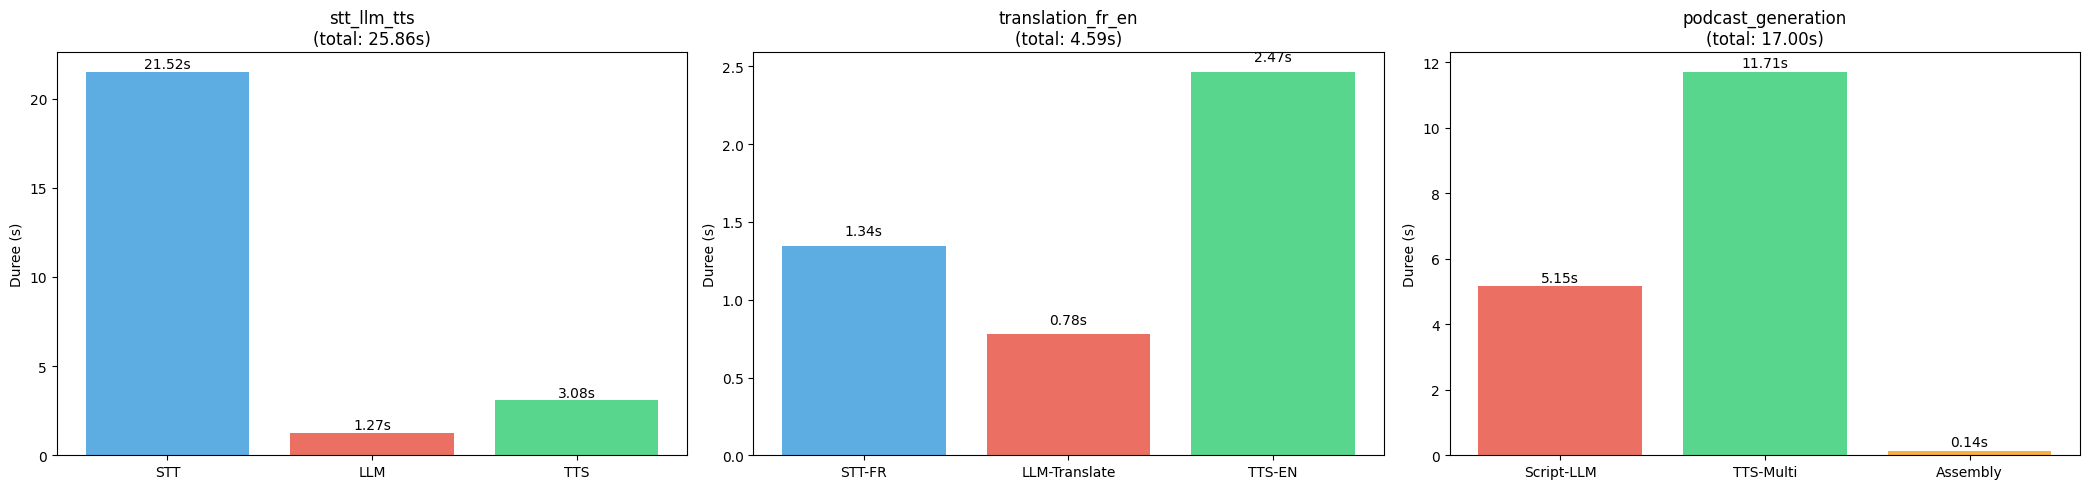

Graphique sauvegarde : pipeline_profiling.png

Recapitulatif des pipelines :
Pipeline                  Duree (s)    Statut     Etapes  
-------------------------------------------------------
stt_llm_tts               25.86        Succes     3/3
translation_fr_en         4.59         Succes     3/3
podcast_generation        17.00        Succes     3/3


In [8]:
# Profilage des performances
print("PROFILAGE DES PERFORMANCES")
print("=" * 45)

if pipeline_results:
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, len(pipeline_results), figsize=(7 * len(pipeline_results), 5))
        if len(pipeline_results) == 1:
            axes = [axes]

        colors_map = {
            'STT': '#3498db', 'STT-FR': '#3498db',
            'LLM': '#e74c3c', 'LLM-Translate': '#e74c3c', 'Script-LLM': '#e74c3c',
            'TTS': '#2ecc71', 'TTS-EN': '#2ecc71', 'TTS-Multi': '#2ecc71',
            'Assembly': '#f39c12'
        }

        for idx, result in enumerate(pipeline_results):
            ax = axes[idx]
            names = [s.name for s in result.steps if s.success]
            durations = [s.duration_s for s in result.steps if s.success]
            colors = [colors_map.get(n, '#95a5a6') for n in names]

            if durations:
                bars = ax.bar(names, durations, color=colors, alpha=0.8)
                for bar, dur in zip(bars, durations):
                    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                           f'{dur:.2f}s', ha='center', va='bottom', fontsize=10)

            ax.set_ylabel('Duree (s)')
            ax.set_title(f'{result.name}\n(total: {result.total_duration_s:.2f}s)')

        plt.tight_layout()
        plt.savefig(str(OUTPUT_DIR / "pipeline_profiling.png"), dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Graphique sauvegarde : pipeline_profiling.png")

    except ImportError:
        print("matplotlib non disponible")

    # Tableau recapitulatif
    print(f"\nRecapitulatif des pipelines :")
    print(f"{'Pipeline':<25} {'Duree (s)':<12} {'Statut':<10} {'Etapes':<8}")
    print("-" * 55)
    for r in pipeline_results:
        status = "Succes" if r.success else "Echec"
        ok_steps = sum(1 for s in r.steps if s.success)
        print(f"{r.name:<25} {r.total_duration_s:<12.2f} {status:<10} {ok_steps}/{len(r.steps)}")
else:
    print("Aucun pipeline execute")

### Interpretation : Profilage

| Pipeline | Etape la plus lente | Optimisation possible |
|----------|--------------------|-----------------------|
| STT->LLM->TTS | LLM (generation) | Utiliser gpt-4o-mini, reduire max_tokens |
| Traduction | Comparable STT/LLM/TTS | Paralleliser STT et TTS si possible |
| Podcast | TTS (N segments) | Paralleliser les appels TTS |

**Points cles** :
1. Le profilage revele que le LLM est souvent le goulot d'etranglement
2. La generation du podcast est dominee par les appels TTS sequentiels
3. L'assemblage est negligeable par rapport aux appels API

In [9]:
# Mode interactif - Pipeline personnalise
if notebook_mode == "interactive" and not skip_widgets:
    print("MODE INTERACTIF - PIPELINE PERSONNALISE")
    print("=" * 50)
    print("\nFournissez un fichier audio pour le pipeline STT->LLM->TTS :")
    print("L'audio sera transcrit, traite par le LLM, et la reponse sera synthetisee.")
    print("(Laissez vide pour passer a la suite)")

    try:
        user_path = input("\nChemin du fichier audio : ")

        if user_path.strip() and openai_available:
            user_file = Path(user_path.strip())
            if user_file.exists():
                print(f"\nTraitement de : {user_file.name}")

                # STT
                with open(user_file, "rb") as f:
                    user_transcript = client.audio.transcriptions.create(
                        model="whisper-1", file=f, response_format="text"
                    )
                print(f"  Transcription : {user_transcript}")

                # LLM
                llm_resp = client.chat.completions.create(
                    model=llm_model,
                    messages=[
                        {"role": "system", "content": "Answer concisely in 2-3 sentences."},
                        {"role": "user", "content": user_transcript}
                    ],
                    max_tokens=200
                )
                answer = llm_resp.choices[0].message.content
                print(f"  Reponse LLM : {answer}")

                # TTS
                tts_resp = client.audio.speech.create(
                    model="tts-1", voice=tts_voice,
                    input=answer, response_format="wav"
                )
                print(f"  Audio genere :")
                display(Audio(data=tts_resp.content, autoplay=False))

                if save_results:
                    out_path = OUTPUT_DIR / f"user_pipeline_answer.wav"
                    with open(out_path, 'wb') as f:
                        f.write(tts_resp.content)
                    print(f"  Sauvegarde : {out_path.name}")
            else:
                print(f"Fichier non trouve : {user_file}")
        else:
            print("Mode interactif ignore")

    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type} - {str(e)[:100]}")
else:
    print("Mode batch - Interface interactive desactivee")

MODE INTERACTIF - PIPELINE PERSONNALISE

Fournissez un fichier audio pour le pipeline STT->LLM->TTS :
L'audio sera transcrit, traite par le LLM, et la reponse sera synthetisee.
(Laissez vide pour passer a la suite)
Mode interactif non disponible (execution automatisee)


## Bonnes pratiques pour les pipelines audio

### Optimisation de la latence

| Technique | Impact | Description |
|-----------|--------|-------------|
| STT local (faster-whisper) | -1 a 2s | Elimine la latence reseau |
| Modele LLM leger (gpt-4o-mini) | -0.5 a 1s | Generation plus rapide |
| TTS streaming | -50% latence | Premier byte audio plus tot |
| Parallelisation | Variable | Traiter plusieurs requetes simultanement |

### Gestion des erreurs

| Pattern | Quand l'utiliser |
|---------|------------------|
| Retry exponentiel | Erreurs reseau / timeout API |
| Fallback local | GPU OOM, API indisponible |
| Circuit breaker | Erreurs repetees (eviter les cascades) |
| Dead letter queue | Erreurs non recuperables (audit) |

In [10]:
# Statistiques de session et prochaines etapes
print("STATISTIQUES DE SESSION")
print("=" * 45)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device : {device}")
print(f"LLM : {llm_model}")
print(f"TTS voice : {tts_voice}")

if gpu_available:
    vram_current = torch.cuda.memory_allocated(0) / (1024**3)
    print(f"VRAM actuelle : {vram_current:.2f} GB")

# Resume des pipelines
if pipeline_results:
    print(f"\nPipelines executes : {len(pipeline_results)}")
    total_time = sum(r.total_duration_s for r in pipeline_results)
    success_count = sum(1 for r in pipeline_results if r.success)
    print(f"Succes : {success_count}/{len(pipeline_results)}")
    print(f"Temps total : {total_time:.2f}s")

    for r in pipeline_results:
        print(f"\n  {r.name} :")
        for s in r.steps:
            status = 'OK' if s.success else f'ERREUR'
            print(f"    {s.name:<15} : {s.duration_s:.2f}s [{status}]")

if save_results:
    saved = list(OUTPUT_DIR.glob('*'))
    total_size = sum(f.stat().st_size for f in saved if f.is_file()) / (1024*1024)
    print(f"\nFichiers sauvegardes : {len(saved)} ({total_size:.1f} MB) dans {OUTPUT_DIR}")

# Liberation memoire
gc.collect()
if gpu_available:
    torch.cuda.empty_cache()
    print(f"Memoire GPU liberee")

print(f"\nPROCHAINES ETAPES")
print(f"1. Explorer l'API Realtime d'OpenAI pour la voix en temps reel (03-3)")
print(f"2. Creer du contenu educatif audio automatise (04-1)")
print(f"3. Combiner audio et generation d'images (04-2)")

print(f"\nNotebook Orchestration de Pipelines Audio termine - {datetime.now().strftime('%H:%M:%S')}")

STATISTIQUES DE SESSION
Date : 2026-02-26 08:22:57
Device : cpu
LLM : gpt-4o-mini
TTS voice : alloy

Pipelines executes : 3
Succes : 3/3
Temps total : 47.45s

  stt_llm_tts :
    STT             : 21.52s [OK]
    LLM             : 1.27s [OK]
    TTS             : 3.08s [OK]

  translation_fr_en :
    STT-FR          : 1.34s [OK]
    LLM-Translate   : 0.78s [OK]
    TTS-EN          : 2.47s [OK]

  podcast_generation :
    Script-LLM      : 5.15s [OK]
    TTS-Multi       : 11.71s [OK]
    Assembly        : 0.14s [OK]

Fichiers sauvegardes : 12 (7.4 MB) dans D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\pipelines

PROCHAINES ETAPES
1. Explorer l'API Realtime d'OpenAI pour la voix en temps reel (03-3)
2. Creer du contenu educatif audio automatise (04-1)
3. Combiner audio et generation d'images (04-2)

Notebook Orchestration de Pipelines Audio termine - 08:22:57
